# Setup

In [1]:
import sys
sys.path.append('/home/arnisaf/mp-tl-study')
from functions.visualization_utils import *

## Load Data

In [7]:
# load baselines: filename!!
with open('results/baselines_freeze_True_pool_False_lr_0.001_MNIST_to_Fashion.json', 'r') as f:
    baselines = json.load(f)
baselines = baselines[1:]

# load results; filename
with open('results/results_freeze_True_reinit_False_pool_False_MNIST_to_Fashion.json', 'r') as f:
    results = json.load(f)

# Run this if the first element of the results is the PARAMS dict
params = results[0]
results = results[1:]
# if not, initialize a params dict -see 3. Init params

data_dicts = baselines + results 
# Create DataFrame from the list of dictionaries
df = pd.DataFrame(data_dicts)

# Rename the columns to match the specified names
df.rename(columns={
    'lr': 'learning rate',
    'sampled_percentage': 'Percentage',
    'sampled_cut_point': 'Cut Point',
    'repeat': 'Trial',
    'train_acc': 'Train Accuracy',
    'test_acc': 'Test Accuracy'
}, inplace=True)

# Display the DataFrame (showing the first few rows for brevity)
df.head()

,learning rate,Percentage,Cut Point,Trial,Train Accuracy,Test Accuracy
0,0.001,0.001,-1,0,1.00,0.624650
1,0.001,0.001,-1,1,1.00,0.619850
2,0.001,0.001,-1,2,0.82,0.561200
3,0.001,0.001,-1,3,0.74,0.639417
4,0.001,0.001,-1,4,0.94,0.576700


In [8]:
# Filter the baselines to these percentages: 0.001, 0.01, 0.1, 0.5, 1.0
# because there are some extra percentages
baselines = [result for result in baselines if result["sampled_percentage"] in [0.005, 0.01, 0.05, 0.1, 0.3]]

results = [result for result in results if result["sampled_percentage"] in [0.005, 0.01, 0.05, 0.1, 0.3]]
data_dicts = baselines + results 
# Create DataFrame from the list of dictionaries
df = pd.DataFrame(data_dicts)

# Rename the columns to match the specified names
df.rename(columns={
    'lr': 'learning rate',
    'sampled_percentage': 'Percentage',
    'sampled_cut_point': 'Cut Point',
    'repeat': 'Trial',
    'train_acc': 'Train Accuracy',
    'test_acc': 'Test Accuracy'
}, inplace=True)

# Display the DataFrame (showing the first few rows for brevity)
df.head()

,learning rate,Percentage,Cut Point,Trial,Train Accuracy,Test Accuracy
0,0.001,0.005,-1,0,0.785185,0.732667
1,0.001,0.005,-1,1,0.937037,0.749617
2,0.001,0.005,-1,2,0.981481,0.742367
3,0.001,0.005,-1,3,0.900000,0.771783
4,0.001,0.005,-1,4,0.988889,0.763833


In [11]:
# OR LOAD ARI Scores
with open("results/ari_scores/ari_scores_finetuned_MNIST_to_Fashion.json", "r") as f:
    ari_scores_all = json.load(f)
df_ari = pd.DataFrame(ari_scores_all)

# Display the DataFrame (showing the first few rows for brevity)
df_ari.head()

,Percentage,Repeat,Num Samples,Layer,Max ARI Score,Avg ARI Score,Dataset,Split
0,0.001,0,0,conv0,38.638659,22.479358,Finetune,Train
1,0.001,0,0,conv1,35.315045,20.162059,Finetune,Train
2,0.001,0,0,conv2,36.774194,19.777657,Finetune,Train
3,0.001,0,0,conv3,34.943236,19.721425,Finetune,Train
4,0.001,0,0,conv4,39.666604,20.522841,Finetune,Train


# 1. The plots
See the documentation (mp-tl-study/example_visualizations.ipynb) for a full list of supported visualizations

### Experimental Plots

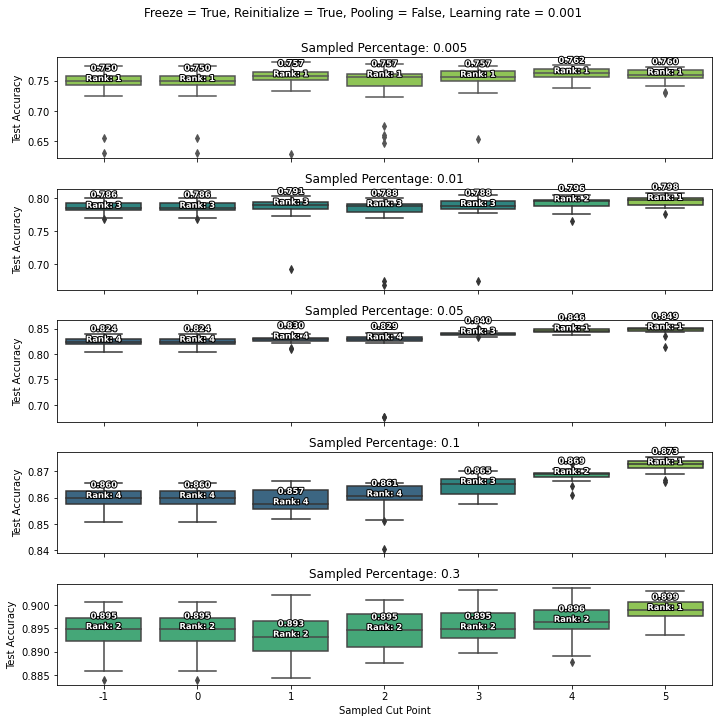

In [9]:
# run statistical tests below to get the df_rankings
_, df_rankings = pairwise_comparison(df=df)
ranks_sorted = box_plot_percentages_experiments(df=df, rank_df=df_rankings, color_ranks=True, params=params, add_baseline=True)

<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

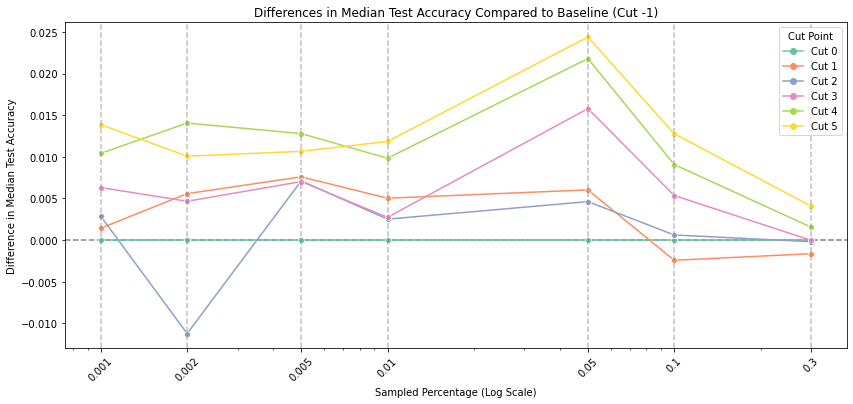

In [4]:
compare_to_baseline_line_plot(df)

<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

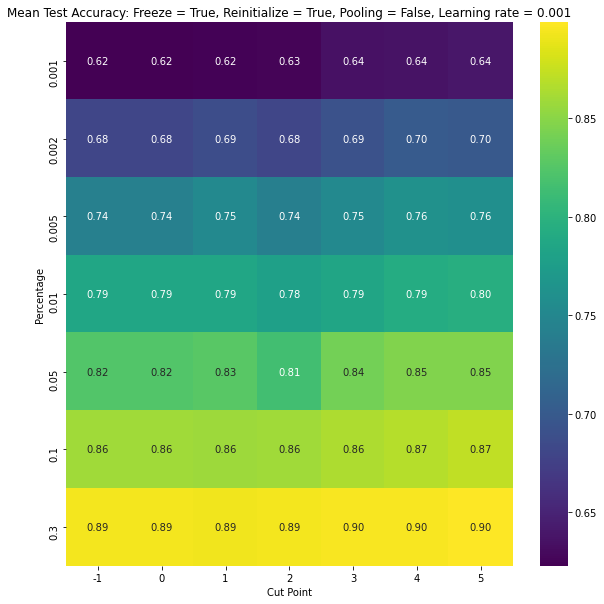

In [5]:
heatmap(df, params, figsize=(10,10))

### ARI Scores Plots

<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

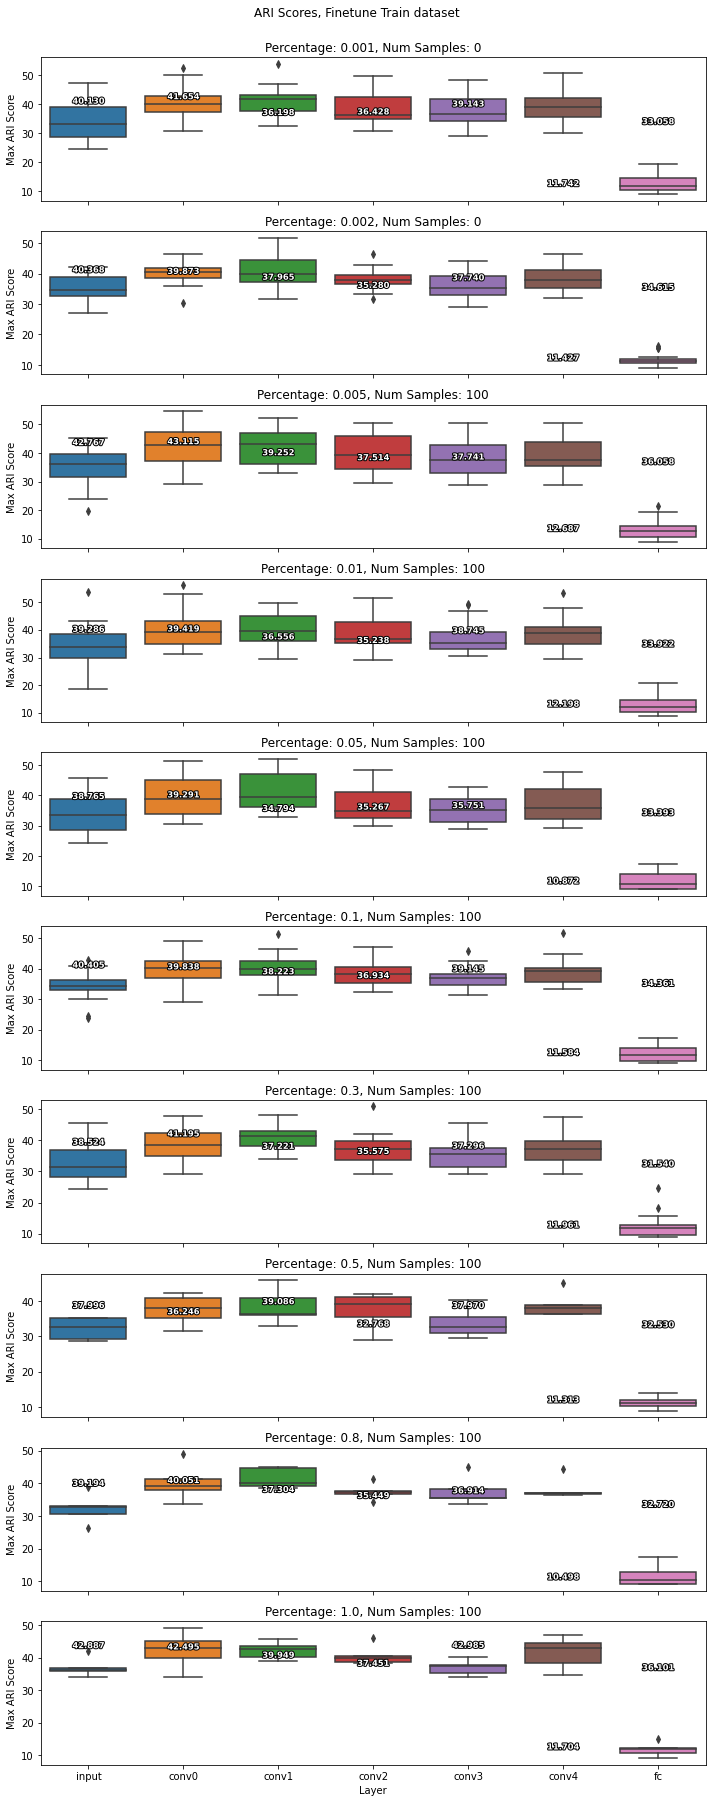

In [12]:
layer_names = ["input", 'conv0', 'conv1', 'conv2', 'conv3', 'conv4', 'fc']
plot_ARI_scores_percentages(df_ari, dataset="Finetune", split="Train", order=layer_names, figsize=(10,25))

# 2. Statistical Tests

### Tables for Ranking Cuts

In [4]:
df_wilcoxon_pairwise, _ = pairwise_comparison(df=df, col="Test Accuracy")

df_wilcoxon_pairwise["statistic"] = df_wilcoxon_pairwise["statistic"].astype(int)

latex_table = df_wilcoxon_pairwise.to_latex(index=False, float_format="%.6f")
# print(latex_table)
# TODO: next, \text{p-value if significant}
# iterate over both the rows in the latex table string and the df_wilcoxon_pairwise
# if the row is significant, add the p-value to the latex table string
rows = latex_table.split("\n")[4:-3]
header = latex_table.split("\n")[:4]
footer = latex_table.split("\n")[-3:]

# iterate over the rows and the df_wilcoxon_pairwise
for i, row in enumerate(rows):
    if df_wilcoxon_pairwise.iloc[i]["is_significant"]:
        # split row with respect to " & ", take the 5th value, encapsulate it in \textbf{} and join them back
        row = row.split(" & ")
        
        # row[4] = "\colorbox[HTML]{B2EAB1}{\\textbf{" + row[4].strip("\\") + "}}"
        # print(row)
        row = " & ".join([str(row[0]).lstrip()[:5]] + row[1:-1])
        row = "\\rowcolor{green!20}\n" + row
    else:
        row = row.split(" & ")
        row = " & ".join([str(row[0]).lstrip()[:5]] + row[1:-1])
    rows[i] = row + " \\\\"

# join the header, rows and footer, putting a "\\" at the end of each row
latex_table = "\n".join(rows)

In [6]:
print(latex_table)

0.001 &            0 &            1 &        142 & 0.596500 \\
0.001 &            0 &            2 &        131 & 0.410765 \\
\rowcolor{green!20}
0.001 &            0 &            3 &         73 & 0.014722 \\
\rowcolor{green!20}
0.001 &            0 &            4 &         86 & 0.039339 \\
\rowcolor{green!20}
0.001 &            0 &            5 &         64 & 0.006726 \\
0.001 &            1 &            2 &        158 & 0.915803 \\
0.001 &            1 &            3 &         90 & 0.051576 \\
0.001 &            1 &            4 &         98 & 0.085139 \\
\rowcolor{green!20}
0.001 &            1 &            5 &         64 & 0.006726 \\
\rowcolor{green!20}
0.001 &            2 &            3 &         80 & 0.025505 \\
\rowcolor{green!20}
0.001 &            2 &            4 &         87 & 0.042150 \\
\rowcolor{green!20}
0.001 &            2 &            5 &         65 & 0.007371 \\
0.001 &            3 &            4 &        143 & 0.615043 \\
0.001 &            3 &            5 &    